In [2]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Load Data

In [2]:
from urllib.request import HTTPError

def load_turnstile_data(urls):
    dfs = []
    for url in urls:
        try:
            df = pd.read_csv(url)
            dfs.append(df)
        except HTTPError as err:
            if err.code == 404:
                continue
            else:
                raise err
    return pd.concat(dfs)

def format_day_month(num):
    return '0' + str(num) if num < 10 else str(num)

def format_year(num):
    return str(num)[-2:]

def generate_url(date):
    y = format_year(date.year)
    m = format_day_month(date.month)
    d = format_day_month(date.day)
    return f'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{y}{m}{d}.txt'

def fetch_data_for_date_range(start, end):
    urls = list(map(generate_url, pd.date_range(start, end, freq="D")))
    return load_turnstile_data(urls)


In [3]:
mta_data = fetch_data_for_date_range('3/1/2019', '4/01/2019')

In [4]:
with open('mta_data_march.pickle', 'wb') as write_file:
    pickle.dump(mta_data, write_file)

In [5]:
mta_data.shape

(1016285, 11)

# 2. Clean Data

## 2.1 Subset Data

In [6]:
mta_data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,03:00:00,REGULAR,6955483,2359112
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,07:00:00,REGULAR,6955494,2359125
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,11:00:00,REGULAR,6955554,2359199
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,15:00:00,REGULAR,6955714,2359248
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,19:00:00,REGULAR,6956004,2359292


In [7]:
subset = mta_data[['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'ENTRIES']].copy()

## 2.2 Convert Dates

In [8]:
subset['datetime'] = pd.to_datetime(subset.DATE + ' ' + subset.TIME)
subset['DATE'] = pd.to_datetime(subset.DATE)
subset['TIME'] = pd.to_datetime(subset.TIME).dt.time

## 2.3 Calculate Entries for Each Time Interval

In [9]:
sorted_data = subset.sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'datetime'])

In [10]:
sorted_data['entries_since_last_record'] = sorted_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['ENTRIES'].diff(1)


In [11]:
sorted_data['time_interval'] = sorted_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['datetime'].diff(1)

In [12]:
sorted_data.head(20)

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,datetime,entries_since_last_record,time_interval
0,A002,R051,02-00-00,59 ST,2019-02-23,03:00:00,6955483,2019-02-23 03:00:00,nan,NaT
1,A002,R051,02-00-00,59 ST,2019-02-23,07:00:00,6955494,2019-02-23 07:00:00,11.000,04:00:00
2,A002,R051,02-00-00,59 ST,2019-02-23,11:00:00,6955554,2019-02-23 11:00:00,60.000,04:00:00
3,A002,R051,02-00-00,59 ST,2019-02-23,15:00:00,6955714,2019-02-23 15:00:00,160.000,04:00:00
4,A002,R051,02-00-00,59 ST,2019-02-23,19:00:00,6956004,2019-02-23 19:00:00,290.000,04:00:00
5,A002,R051,02-00-00,59 ST,2019-02-23,23:00:00,6956147,2019-02-23 23:00:00,143.000,04:00:00
6,A002,R051,02-00-00,59 ST,2019-02-24,03:00:00,6956177,2019-02-24 03:00:00,30.000,04:00:00
7,A002,R051,02-00-00,59 ST,2019-02-24,07:00:00,6956184,2019-02-24 07:00:00,7.000,04:00:00
8,A002,R051,02-00-00,59 ST,2019-02-24,11:00:00,6956215,2019-02-24 11:00:00,31.000,04:00:00
9,A002,R051,02-00-00,59 ST,2019-02-24,15:00:00,6956315,2019-02-24 15:00:00,100.000,04:00:00


## 2.4 Visualize Outliers

Text(0.5, 1.0, 'Raw')

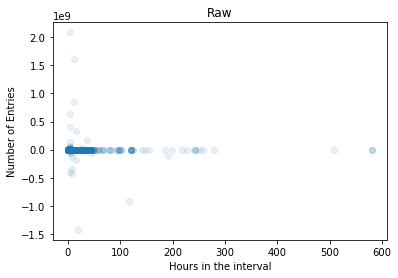

In [13]:
interval_in_hours = sorted_data.time_interval.dt.total_seconds() / 3600

plt.scatter(interval_in_hours, sorted_data.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Raw')

(-3000, 5000)

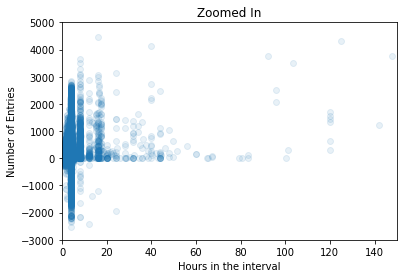

In [14]:
plt.scatter(interval_in_hours, sorted_data.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Zoomed In')
plt.xlim([0,150])
plt.ylim([-3000, 5000])

Conclusion: high entries values are not due to long time intervals for counting

In [15]:
sorted_data.time_interval.quantile(0.999).total_seconds() / 3600

8.0

In [16]:
sorted_data.entries_since_last_record.quantile(0.999)

1913.0

In [17]:
sorted_data.entries_since_last_record.quantile(0.0091)

-1.0

Conclusion: Could remove all intervals above 8 hrs, all negative entries values, and all entries values above 1913 and still only remove ~1.1% of the data set

## 2.5 Calculate Outliers Within A Turnstile

In [18]:
sorted_data['unit_mean'] = sorted_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['entries_since_last_record'].transform('mean')

In [19]:
sorted_data['unit_std'] = sorted_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['entries_since_last_record'].transform('std')

In [20]:
sorted_data['deviations'] = (sorted_data['entries_since_last_record'] - sorted_data['unit_mean']) / sorted_data['unit_std']


In [21]:
sorted_data.describe([0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

,ENTRIES,entries_since_last_record,time_interval,unit_mean,unit_std,deviations
count,1016285.000,1011402.000,1011402,1016271.000,1016265.000,960222.000
mean,40529956.499,2066.048,0 days 03:59:39.541903,2064.916,151249.407,0.000
std,208311278.270,3421941.072,0 days 01:36:09.342946,234270.500,3418951.384,0.998
min,0.000,-1428035580.000,0 days 00:00:00,-7069372.589,0.000,-14.933
0.01%,0.000,-1791052.851,0 days 00:00:08,-7069372.589,0.000,-13.711
0.1%,0.000,-825.000,0 days 00:01:20,-642517.976,0.000,-1.785
1%,0.000,0.000,0 days 01:20:56,-9349.700,0.000,-1.351
10%,18391.000,0.000,0 days 04:00:00,0.048,0.951,-0.991
50%,2285667.000,68.000,0 days 04:00:00,137.986,143.202,-0.186
90%,15417265.600,479.000,0 days 04:00:00,364.577,380.190,1.428


## 2.6 Remove Within Unit Outliers

In [22]:
no_unit_outliers = sorted_data[((sorted_data.deviations > -5) & (sorted_data.deviations < 5)) | sorted_data.deviations.isna()]

In [23]:
no_unit_outliers.shape[0] / sorted_data.shape[0]

0.9990711267016634

## 2.7 Visualize Without Unit Outliers

Text(0.5, 1.0, 'Raw')

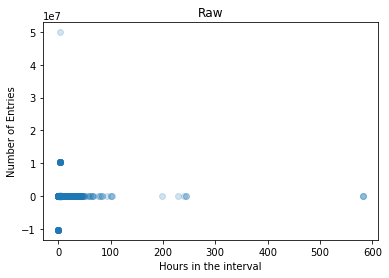

In [24]:
interval_in_hours = no_unit_outliers.time_interval.dt.total_seconds() / 3600

plt.scatter(interval_in_hours, no_unit_outliers.entries_since_last_record, alpha=0.2)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Raw')


In [25]:
no_unit_outliers.describe([0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

,ENTRIES,entries_since_last_record,time_interval,unit_mean,unit_std,deviations
count,1015341.000,1010458.000,1010458,1015327.000,1015321.000,959278.000
mean,40537504.316,217.006,0 days 03:59:14.722463,2058.965,150540.900,-0.004
std,208328233.072,82970.949,0 days 01:16:05.855198,233812.099,3411897.994,0.955
min,0.000,-10314855.000,0 days 00:00:00,-7069372.589,0.000,-4.948
0.01%,0.000,-1658.954,0 days 00:00:18,-7069372.589,0.000,-2.750
0.1%,0.000,-727.000,0 days 00:01:20,-642517.976,0.000,-1.665
1%,0.000,0.000,0 days 01:20:59,-9349.700,0.000,-1.349
10%,18646.000,0.000,0 days 04:00:00,0.048,0.968,-0.991
50%,2290987.000,68.000,0 days 04:00:00,138.129,143.222,-0.187
90%,15416988.000,478.000,0 days 04:00:00,364.577,380.190,1.420


## 2.8 Remove Extreme Entries Outliers

In [26]:
no_extreme_outliers = no_unit_outliers[
    (no_unit_outliers.entries_since_last_record < no_unit_outliers.entries_since_last_record.quantile(0.99995)) & 
    (no_unit_outliers.entries_since_last_record > no_unit_outliers.entries_since_last_record.quantile(0.00005))]

Text(0.5, 1.0, 'Raw')

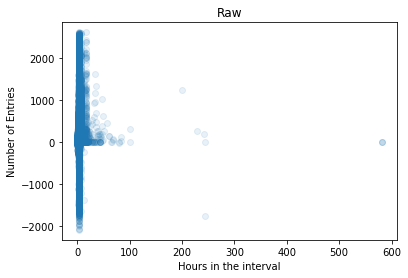

In [27]:
interval_in_hours = no_extreme_outliers.time_interval.dt.total_seconds() / 3600

plt.scatter(interval_in_hours, no_extreme_outliers.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Raw')

## 2.9 Remove Extreme Interval Outliers

In [28]:
no_extreme_outliers.describe([0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

,ENTRIES,entries_since_last_record,time_interval,unit_mean,unit_std,deviations
count,1010356.000,1010356.000,1010356,1010356.000,1010353.000,959176.000
mean,40529168.748,167.707,0 days 03:59:13.490501,2044.986,150125.708,-0.004
std,208302536.217,257.439,0 days 01:15:26.454563,233540.788,3408202.641,0.955
min,0.000,-2092.000,0 days 00:00:00,-7069372.589,0.000,-4.530
0.01%,0.000,-1505.929,0 days 00:00:31,-7069372.589,0.000,-2.689
0.1%,0.000,-706.645,0 days 00:01:20,-642517.976,0.000,-1.652
1%,0.000,0.000,0 days 01:21:15,-9349.700,0.000,-1.349
10%,18664.000,0.000,0 days 04:00:00,0.048,0.968,-0.991
50%,2290595.000,68.000,0 days 04:00:00,138.129,143.222,-0.187
90%,15413273.500,478.000,0 days 04:00:00,364.577,379.898,1.419


In [29]:
no_extreme_interval_outliers = no_extreme_outliers[no_extreme_outliers.time_interval < no_extreme_outliers.time_interval.quantile(0.99995)]

In [30]:
no_extreme_interval_outliers.shape[0] / no_extreme_outliers.shape[0]

0.9999495227424788

Text(0.5, 1.0, 'Raw')

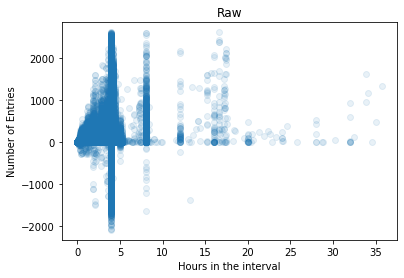

In [31]:
interval_in_hours = no_extreme_interval_outliers.time_interval.dt.total_seconds() / 3600

plt.scatter(interval_in_hours, no_extreme_interval_outliers.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Raw')

In [32]:
# Status - the percent we've removed thus far
1 - (no_extreme_interval_outliers.shape[0] / mta_data.shape[0])

0.005884176190733892

## 2.10 Investigate Negatives

In [33]:
no_extreme_interval_outliers['always_decreasing'] = no_extreme_interval_outliers.groupby(['C/A', 'UNIT', 'SCP', 'STATION']).transform(lambda s: s.is_monotonic_decreasing)['ENTRIES']


/Applications/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
always_decreasing = no_extreme_interval_outliers[
    (no_extreme_interval_outliers.entries_since_last_record < 0) &
    no_extreme_interval_outliers.always_decreasing &
    no_extreme_interval_outliers.unit_mean != 0
]

In [35]:
always_decreasing.describe([0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

,ENTRIES,entries_since_last_record,time_interval,unit_mean,unit_std,deviations
count,8607.000,8607.000,8607,8607.000,8607.000,8607.000
mean,1198984225.002,-294.060,0 days 03:57:03.137911,-290.659,269.349,-0.031
std,661311811.510,331.913,0 days 00:29:02.202133,156.279,140.238,0.996
min,8695.000,-2092.000,0 days 00:00:56,-660.356,0.591,-4.530
0.01%,8976.416,-2082.533,0 days 00:01:14.933200,-660.356,0.591,-4.530
0.1%,10617.356,-1884.970,0 days 00:01:20,-660.356,0.591,-3.487
1%,25203.800,-1537.940,0 days 00:31:36.320000,-660.356,43.866,-2.711
10%,98304563.000,-715.400,0 days 04:00:00,-549.857,83.564,-1.566
50%,1291172679.000,-186.000,0 days 04:00:00,-279.582,262.773,0.218
90%,1942995409.400,-14.000,0 days 04:00:00,-84.701,492.438,1.007


Text(0.5, 1.0, 'Raw')

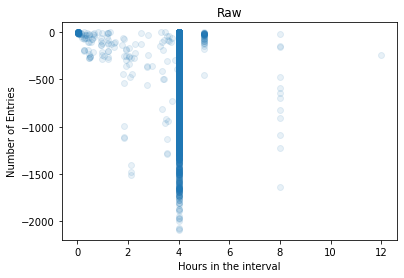

In [36]:
interval_in_hours = always_decreasing.time_interval.dt.total_seconds() / 3600

plt.scatter(interval_in_hours, always_decreasing.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Raw')

In [37]:
always_decreasing.shape[0] / no_extreme_interval_outliers[no_extreme_interval_outliers.entries_since_last_record < 0].shape[0]

0.9518911745189117

95% of negative values are in turnstiles that are always decreasing

## 2.11 Flip Reasonable Negatives

In [38]:
copy = no_extreme_interval_outliers.copy()

In [39]:
always_decreasing.entries_since_last_record.quantile(0.01)

-1537.94

In [40]:
copy['corrected_entries_since_last_record'] = np.where(
    (
        (copy.entries_since_last_record < 0) &
        copy.always_decreasing &
        copy.unit_mean != 0 &
        (copy.entries_since_last_record > always_decreasing.entries_since_last_record.quantile(0.01))
    ),
    np.abs(copy.entries_since_last_record),
    copy.entries_since_last_record
)

## 2.12 Drop Remaining Negatives

In [41]:
cleaned = copy[copy.corrected_entries_since_last_record >= 0]

In [42]:
cleaned.shape[0] / mta_data.shape[0]

0.9936877942703081

We removed 0.7% of the data

Text(0.5, 1.0, 'Cleaned')

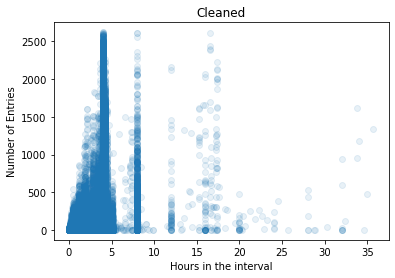

In [43]:
interval_in_hours = cleaned.time_interval.dt.total_seconds() / 3600

plt.scatter(interval_in_hours, cleaned.corrected_entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Cleaned')

## 2.13 Select Relevant Columns

In [44]:
relevant = cleaned[['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'datetime', 'corrected_entries_since_last_record', 'time_interval']]
                   

In [45]:
relevant = relevant.rename(columns={'corrected_entries_since_last_record': 'entries'})

In [46]:
relevant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1009870 entries, 1 to 204594
Data columns (total 9 columns):
C/A              1009870 non-null object
UNIT             1009870 non-null object
SCP              1009870 non-null object
STATION          1009870 non-null object
DATE             1009870 non-null datetime64[ns]
TIME             1009870 non-null object
datetime         1009870 non-null datetime64[ns]
entries          1009870 non-null float64
time_interval    1009870 non-null timedelta64[ns]
dtypes: datetime64[ns](2), float64(1), object(5), timedelta64[ns](1)
memory usage: 77.0+ MB


In [47]:
relevant.head()

,C/A,UNIT,SCP,STATION,DATE,TIME,datetime,entries,time_interval
1,A002,R051,02-00-00,59 ST,2019-02-23,07:00:00,2019-02-23 07:00:00,11.000,04:00:00
2,A002,R051,02-00-00,59 ST,2019-02-23,11:00:00,2019-02-23 11:00:00,60.000,04:00:00
3,A002,R051,02-00-00,59 ST,2019-02-23,15:00:00,2019-02-23 15:00:00,160.000,04:00:00
4,A002,R051,02-00-00,59 ST,2019-02-23,19:00:00,2019-02-23 19:00:00,290.000,04:00:00
5,A002,R051,02-00-00,59 ST,2019-02-23,23:00:00,2019-02-23 23:00:00,143.000,04:00:00


# 3. Store Data

In [48]:
with open('cleaned_mta_data_march.pickle', 'wb') as write_file:
    pickle.dump(relevant, write_file)

# 4. Adjust Intervals That Cross Days

## 4.1 Explore Intervals 

In [49]:
counts = relevant.TIME.value_counts()
counts.head(20)

04:00:00    76541
08:00:00    76492
20:00:00    76428
16:00:00    76403
12:00:00    76385
00:00:00    73916
11:00:00    37790
07:00:00    37784
23:00:00    37764
15:00:00    37737
19:00:00    37703
09:00:00    37650
05:00:00    37650
21:00:00    37610
17:00:00    37605
13:00:00    37573
01:00:00    35824
03:00:00    35308
14:00:00     2820
22:00:00     2817
Name: TIME, dtype: int64

In [50]:
relevant.iloc[0].TIME

datetime.time(7, 0)

In [53]:
relevant[relevant.TIME == datetime.time(0, 0)]

,C/A,UNIT,SCP,STATION,DATE,TIME,datetime,entries,time_interval
11,A002,R051,02-00-00,59 ST,2019-03-11,00:00:00,2019-03-11,80.000,04:00:00
17,A002,R051,02-00-00,59 ST,2019-03-12,00:00:00,2019-03-12,175.000,04:00:00
23,A002,R051,02-00-00,59 ST,2019-03-13,00:00:00,2019-03-13,229.000,04:00:00
32,A002,R051,02-00-00,59 ST,2019-03-14,00:00:00,2019-03-14,217.000,04:00:00
39,A002,R051,02-00-00,59 ST,2019-03-15,00:00:00,2019-03-15,249.000,04:00:00
...,...,...,...,...,...,...,...,...,...
203968,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-03-06,00:00:00,2019-03-06,0.000,04:00:00
203974,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-03-07,00:00:00,2019-03-07,0.000,04:00:00
203981,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-03-08,00:00:00,2019-03-08,0.000,04:00:00
201750,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-03-09,00:00:00,2019-03-09,0.000,04:00:00


In [52]:
import datetime

d1 = pd.to_datetime('1/2/2019 03:00')
d2 = d1 - pd.Timedelta('4 hours')

In [54]:
d1.day

2

In [55]:
d2.day

1

In [56]:
td = pd.Timedelta('4 hours')
td.total_seconds() / 3600

4.0

In [57]:
pd.to_datetime('1/2/2019 03:00').hour

3

In [58]:
more_than_one_day = relevant[relevant.datetime.dt.hour < (relevant.time_interval.dt.total_seconds() / 3600)]

more_than_one_day.shape[0] / relevant.shape[0]

0.16440333904363927

16% of the records are overlapping a day

In [59]:
and_at_midnight = more_than_one_day[more_than_one_day.TIME == datetime.time(0, 0)]
and_at_midnight.shape[0] / more_than_one_day.shape[0]

0.44520737715779457

Of that 16%, almost half of them are at midnight

In [60]:
(relevant[relevant.time_interval.dt.total_seconds() >= (24 * 3600)].shape[0] / relevant.shape[0]) * 100

0.0028716567478982444

Less than 0.001% of the records are larger than 1 day. Perhaps remove

Plan Below:

In [ ]:
# remove records with intervals >= 24 hours
# add a starting datetime field
    # start_datetime = datetime - time_interval
    # rename datetime -> 'end_datetime'
# drop DATE, TIME
# replace all datetime values of 00:00 with 23:59 of the prev day
 
# if starting_datetime and end_datetime are on different days
    # insert tomorrow's record:
        # station values: same
        # start_datetime: 00:00
        # end_datetime: end_datetime from record
        # entries: proportional
        # time_interval: end_datetime - start_datetime
    # ajust values:
        # entries: proportion of interval on the starting day
        # end_datetime: 23:59
        # time_interval: end_datetime - start_datetime
        

## 4.2 Clean Datetime Fields

In [61]:
less_than_24 = relevant[relevant.time_interval < pd.Timedelta('24 hours')].copy()

In [62]:
less_than_24['start_datetime'] = less_than_24.datetime - less_than_24.time_interval

In [63]:
less_than_24 = less_than_24.rename(columns={ 'datetime': 'end_datetime'})

In [64]:
less_than_24 = less_than_24.drop(columns=['DATE', 'TIME'])

In [65]:
less_than_24['end_datetime'] = np.where(
    less_than_24.end_datetime.dt.hour == 0,
    less_than_24.end_datetime - pd.Timedelta('1 second'),
    less_than_24.end_datetime
)

## 4.3 Split Entries That Overlap Days

### 4.3.1 Append Records for Next Day's Entries

In [66]:
less_than_24.head()

,C/A,UNIT,SCP,STATION,end_datetime,entries,time_interval,start_datetime
1,A002,R051,02-00-00,59 ST,2019-02-23 07:00:00,11.000,04:00:00,2019-02-23 03:00:00
2,A002,R051,02-00-00,59 ST,2019-02-23 11:00:00,60.000,04:00:00,2019-02-23 07:00:00
3,A002,R051,02-00-00,59 ST,2019-02-23 15:00:00,160.000,04:00:00,2019-02-23 11:00:00
4,A002,R051,02-00-00,59 ST,2019-02-23 19:00:00,290.000,04:00:00,2019-02-23 15:00:00
5,A002,R051,02-00-00,59 ST,2019-02-23 23:00:00,143.000,04:00:00,2019-02-23 19:00:00


In [67]:
def set_datetime_to_midnight(date):
    return date.replace(hour=0, minute=0, second=0)

In [68]:
new_records = less_than_24[less_than_24.start_datetime.dt.day != less_than_24.end_datetime.dt.day].copy()
new_records['new_start_datetime'] = new_records.end_datetime.map(set_datetime_to_midnight)
new_records['interval_on_that_day'] = new_records.end_datetime - new_records.new_start_datetime

In [69]:
new_records['proportional_entries'] = new_records.entries * (new_records.interval_on_that_day / new_records.time_interval)

In [70]:
new_records['entries'] = new_records['proportional_entries']
new_records['time_interval'] = new_records['interval_on_that_day']
new_records['start_datetime'] = new_records['new_start_datetime']
records_to_add = new_records[['C/A','UNIT','SCP','STATION','end_datetime','entries','time_interval','start_datetime']]

In [71]:
with_split = less_than_24.append(records_to_add)

### 4.3.2 Reset Records With Only Today's Value

In [72]:
with_split['new_end_datetime'] = np.where(
    with_split.start_datetime.dt.day != with_split.end_datetime.dt.day,
    with_split.end_datetime.map(lambda date: (date - pd.Timedelta('1 day')).replace(hour=23, minute=59, second=59)),
    with_split.end_datetime
)

In [73]:
with_split[with_split.end_datetime != with_split.new_end_datetime].new_end_datetime.unique()

array(['2019-02-23T23:59:59.000000000', '2019-02-24T23:59:59.000000000',
       '2019-02-25T23:59:59.000000000', '2019-02-26T23:59:59.000000000',
       '2019-02-27T23:59:59.000000000', '2019-02-28T23:59:59.000000000',
       '2019-03-01T23:59:59.000000000', '2019-03-02T23:59:59.000000000',
       '2019-03-03T23:59:59.000000000', '2019-03-04T23:59:59.000000000',
       '2019-03-05T23:59:59.000000000', '2019-03-06T23:59:59.000000000',
       '2019-03-07T23:59:59.000000000', '2019-03-08T23:59:59.000000000',
       '2019-03-09T23:59:59.000000000', '2019-03-10T23:59:59.000000000',
       '2019-03-11T23:59:59.000000000', '2019-03-12T23:59:59.000000000',
       '2019-03-13T23:59:59.000000000', '2019-03-14T23:59:59.000000000',
       '2019-03-15T23:59:59.000000000', '2019-03-16T23:59:59.000000000',
       '2019-03-17T23:59:59.000000000', '2019-03-18T23:59:59.000000000',
       '2019-03-19T23:59:59.000000000', '2019-03-20T23:59:59.000000000',
       '2019-03-21T23:59:59.000000000', '2019-03-22

In [74]:
with_split['interval_on_that_day'] = with_split.new_end_datetime - with_split.start_datetime

In [75]:
with_split['adjusted_entries'] = np.where(
    with_split.start_datetime.dt.day != with_split.end_datetime.dt.day,
    with_split.entries * (with_split.interval_on_that_day / with_split.time_interval),
    with_split.entries
)

/Applications/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py:597: RuntimeWarning: invalid value encountered in true_divide
  return other / self._data


In [76]:
with_split[with_split.entries != with_split.adjusted_entries].sample(10)

,C/A,UNIT,SCP,STATION,end_datetime,entries,time_interval,start_datetime,new_end_datetime,interval_on_that_day,adjusted_entries
70496,N202,R315,00-00-02,155 ST,2019-03-15 01:00:00,68.000,04:00:00,2019-03-14 21:00:00,2019-03-14 23:59:59,02:59:59,50.995
189686,R534,R055,01-00-02,FLUSHING-MAIN,2019-02-25 03:00:00,6.000,04:00:00,2019-02-24 23:00:00,2019-02-24 23:59:59,00:59:59,1.500
52069,N063A,R011,00-00-03,42 ST-PORT AUTH,2019-03-02 03:00:00,149.000,04:00:00,2019-03-01 23:00:00,2019-03-01 23:59:59,00:59:59,37.240
89362,N340A,R115,01-03-00,169 ST,2019-03-05 03:00:00,19.000,04:00:00,2019-03-04 23:00:00,2019-03-04 23:59:59,00:59:59,4.749
95057,N501A,R020,02-00-00,47-50 STS ROCK,2019-02-26 03:00:00,83.000,04:00:00,2019-02-25 23:00:00,2019-02-25 23:59:59,00:59:59,20.744
66470,N124,R103,00-03-02,BROADWAY JCT,2019-03-04 03:00:00,103.000,04:00:00,2019-03-03 23:00:00,2019-03-03 23:59:59,00:59:59,25.743
127096,R101,R001,02-00-03,SOUTH FERRY,2019-03-23 01:00:00,46.000,04:00:00,2019-03-22 21:00:00,2019-03-22 23:59:59,02:59:59,34.497
97657,N512,R163,00-00-02,14 ST,2019-03-10 04:00:00,89.000,05:00:00,2019-03-09 23:00:00,2019-03-09 23:59:59,00:59:59,17.795
184471,R519,R223,00-03-01,46 ST BLISS ST,2019-03-07 03:00:00,10.000,04:00:00,2019-03-06 23:00:00,2019-03-06 23:59:59,00:59:59,2.499
44795,N016A,R296,00-03-02,163 ST-AMSTERDM,2019-03-26 01:00:00,7.000,04:00:00,2019-03-25 21:00:00,2019-03-25 23:59:59,02:59:59,5.250


In [77]:
with_split[with_split.start_datetime.dt.day != with_split.new_end_datetime.dt.day]

,C/A,UNIT,SCP,STATION,end_datetime,entries,time_interval,start_datetime,new_end_datetime,interval_on_that_day,adjusted_entries


In [78]:
clean_columns = with_split[['C/A', 'UNIT', 'SCP', 'STATION', 'start_datetime', 'new_end_datetime', 'interval_on_that_day', 'adjusted_entries']]

In [79]:
clean_columns = clean_columns.rename(columns={ 'new_end_datetime': 'end_datetime', 'adjusted_entries': 'entries' })


In [80]:
clean_columns.sample(10)

,C/A,UNIT,SCP,STATION,start_datetime,end_datetime,interval_on_that_day,entries
167411,R293,R133,00-00-05,MOSHOLU PKWY,2019-03-15 21:00:00,2019-03-15 23:59:59,02:59:59,57.745
98163,N519,R461,00-03-01,B'WAY-LAFAYETTE,2019-03-10 17:00:00,2019-03-10 21:00:00,04:00:00,549.000
2361,A015,R081,00-00-03,49 ST,2019-03-09 11:00:00,2019-03-09 15:00:00,04:00:00,195.000
51691,N067,R012,00-00-02,34 ST-PENN STA,2019-03-09 19:00:00,2019-03-09 23:00:00,04:00:00,55.000
10706,A060,R001,00-00-00,WHITEHALL S-FRY,2019-03-21 17:00:00,2019-03-21 21:00:00,04:00:00,483.000
71755,N203,R195,00-03-00,161/YANKEE STAD,2019-02-26 00:00:00,2019-02-26 03:22:00,03:22:00,0.000
151675,R210,R044,00-03-03,BROOKLYN BRIDGE,2019-03-07 00:00:00,2019-03-07 03:00:00,03:00:00,15.000
167883,R291,R183,00-00-01,BEDFORD PK BLVD,2019-03-08 11:00:00,2019-03-08 15:00:00,04:00:00,186.000
146670,R194,R040,00-00-02,231 ST,2019-03-01 19:00:00,2019-03-01 23:00:00,04:00:00,207.000
136888,R141,R031,00-03-00,34 ST-PENN STA,2019-03-23 20:00:00,2019-03-23 23:59:59,03:59:59,279.000


### 4.3.3 Validation

In [81]:
num_in_less_than_24 = less_than_24.shape[0]
num_across_days = less_than_24[less_than_24.start_datetime.dt.day != less_than_24.end_datetime.dt.day].shape[0]
num_in_clean_cols = clean_columns.shape[0]

num_in_clean_cols == (num_in_less_than_24 + num_across_days)

True

In [82]:
clean_columns[clean_columns.start_datetime.dt.day != clean_columns.end_datetime.dt.day].shape[0]

0

In [83]:
clean_columns.shape[0] / mta_data.shape[0]

1.0821472323216421

## 4.4 Store Data

In [84]:
with open('super_cleaned_mta_data_march.pickle', 'wb') as write_file:
    pickle.dump(clean_columns, write_file)

In [85]:
clean_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1099770 entries, 1 to 204589
Data columns (total 8 columns):
C/A                     1099770 non-null object
UNIT                    1099770 non-null object
SCP                     1099770 non-null object
STATION                 1099770 non-null object
start_datetime          1099770 non-null datetime64[ns]
end_datetime            1099770 non-null datetime64[ns]
interval_on_that_day    1099770 non-null timedelta64[ns]
entries                 1099770 non-null float64
dtypes: datetime64[ns](2), float64(1), object(4), timedelta64[ns](1)
memory usage: 75.5+ MB


# Explore

In [ ]:
res = clean_columns.groupby(['C/A', 'UNIT', 'SCP', 'STATION', clean_columns.start_datetime.dt.strftime('%m/%d/%y')]).agg({ 'entries': 'sum'})

In [ ]:
pd.to_datetime('1/1/2019').strftime('%m/%d/%y')

In [ ]:
res.describe()

# TZ Explore

In [ ]:
date['year'] = ['date'].dt.year 

# Average entries per day, per station, as histogram

In [3]:
with open('super_cleaned_mta_data_march.pickle', 'rb') as read_file:
    clean_columns=pickle.load(read_file)

***making a day of the week column

In [4]:
clean_columns['DATE'] = clean_columns.start_datetime.dt.day_name
clean_columns['DATE'] = clean_columns.start_datetime.dt.day_name()
clean_columns['DAY'] = clean_columns['DATE']

In [ ]:
***group by station, DAY OF THE WEEK, aggregate on entries

In [5]:
daily_entries_by_station_by_day = (clean_columns
.groupby([clean_columns.start_datetime.dt.date,'STATION','DAY'])
 .agg({'entries':'sum'})
 .reset_index()
)

In [56]:
daily_entries_by_station

,start_datetime,STATION,entries
0,2019-02-23,1 AV,2.000
1,2019-02-23,103 ST,17980.000
2,2019-02-23,103 ST-CORONA,13481.976
3,2019-02-23,104 ST,2191.997
4,2019-02-23,110 ST,5909.234
...,...,...,...
13207,2019-03-29,WOODLAWN,6256.000
13208,2019-03-29,WORLD TRADE CTR,16794.000
13209,2019-03-29,WTC-CORTLANDT,13077.500
13210,2019-03-29,YORK ST,11649.500


***group by station, aggregate on entries

In [66]:
dailies = daily_entries_by_station.groupby(['STATION'],as_index=False).entries.sum()
dailies.sort_values(by='entries').tail(20).sum()

STATION    50 STJKSN HT-ROOSVLT47-50 STS ROCKFLUSHING-MAI...
entries                                         52876519.113
dtype: object

In [67]:
52876519/174685473

0.30269557102782096

In [8]:
daily_entries_by_station = (clean_columns
.groupby([clean_columns.start_datetime.dt.date,'STATION'])
 .agg({'entries':'sum'})
 .reset_index()
)

In [28]:
daily_entries_by_station.start_datetime.max()

datetime.date(2019, 3, 29)

***not all stations have the same number of entries (35 v 25)

Find each station's daily mean

In [10]:
station_daily_entries_mean = daily_entries_by_station.groupby(['STATION'],as_index=False).entries.mean()

In [11]:
station_dailies_top  = station_daily_entries_mean.sort_values(by='entries',ascending=False)

In [13]:
top_20 = station_dailies_top.head(20)
top_20

,STATION,entries
61,34 ST-PENN STA,146510.447
233,GRD CNTRL-42 ST,129075.480
59,34 ST-HERALD SQ,103765.304
46,23 ST,99858.757
68,42 ST-PORT AUTH,91155.706
14,14 ST-UNION SQ,89622.213
352,TIMES SQ-42 ST,87329.038
226,FULTON ST,80825.348
110,86 ST,73716.879
9,125 ST,70553.348


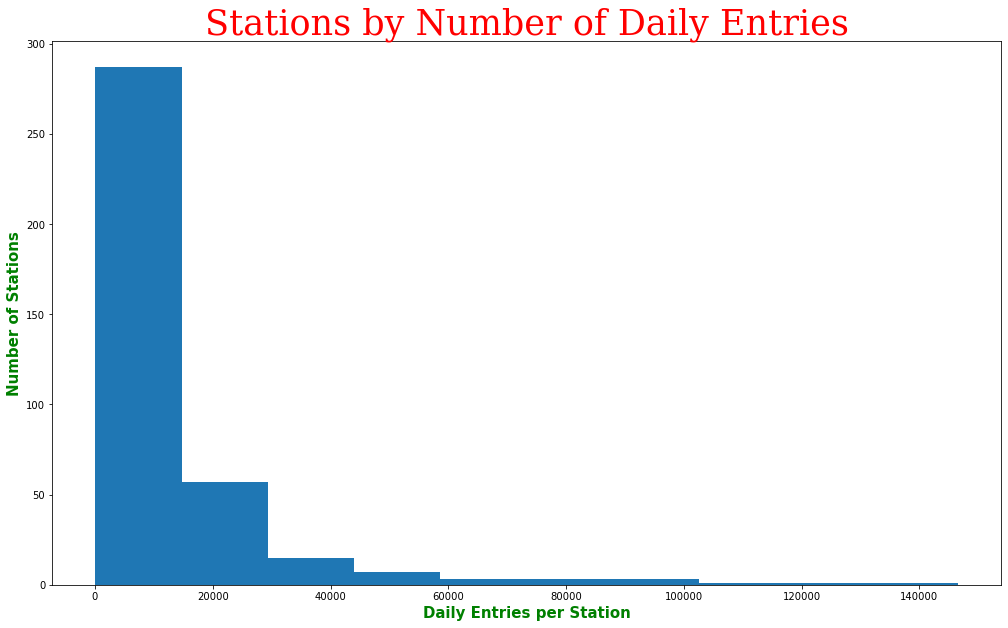

In [95]:
x = station_daily_entries_mean.entries
y = station_daily_entries_mean.STATION.count()
plt.figure(figsize=[17,10])
plt.hist(x,bins=10)
plt.xlabel('Daily Entries per Station',fontsize = 15, weight = 'bold',color='green')
plt.ylabel('Number of Stations',fontsize = 15, weight = 'bold',color='green');
plt.title('Stations by Number of Daily Entries',family='serif',fontsize = 35,loc='center',color='r');

In [99]:
top_20 = station_daily_entries_mean.sort_values(by='entries',ascending=False).head(20)
top_20

,STATION,entries
61,34 ST-PENN STA,146510.447
233,GRD CNTRL-42 ST,129075.480
59,34 ST-HERALD SQ,103765.304
46,23 ST,99858.757
68,42 ST-PORT AUTH,91155.706
14,14 ST-UNION SQ,89622.213
352,TIMES SQ-42 ST,87329.038
226,FULTON ST,80825.348
110,86 ST,73716.879
9,125 ST,70553.348


In [ ]:
station_dailies_ascending = station_dailies_top.sort_values(by='entries',ascending=False)

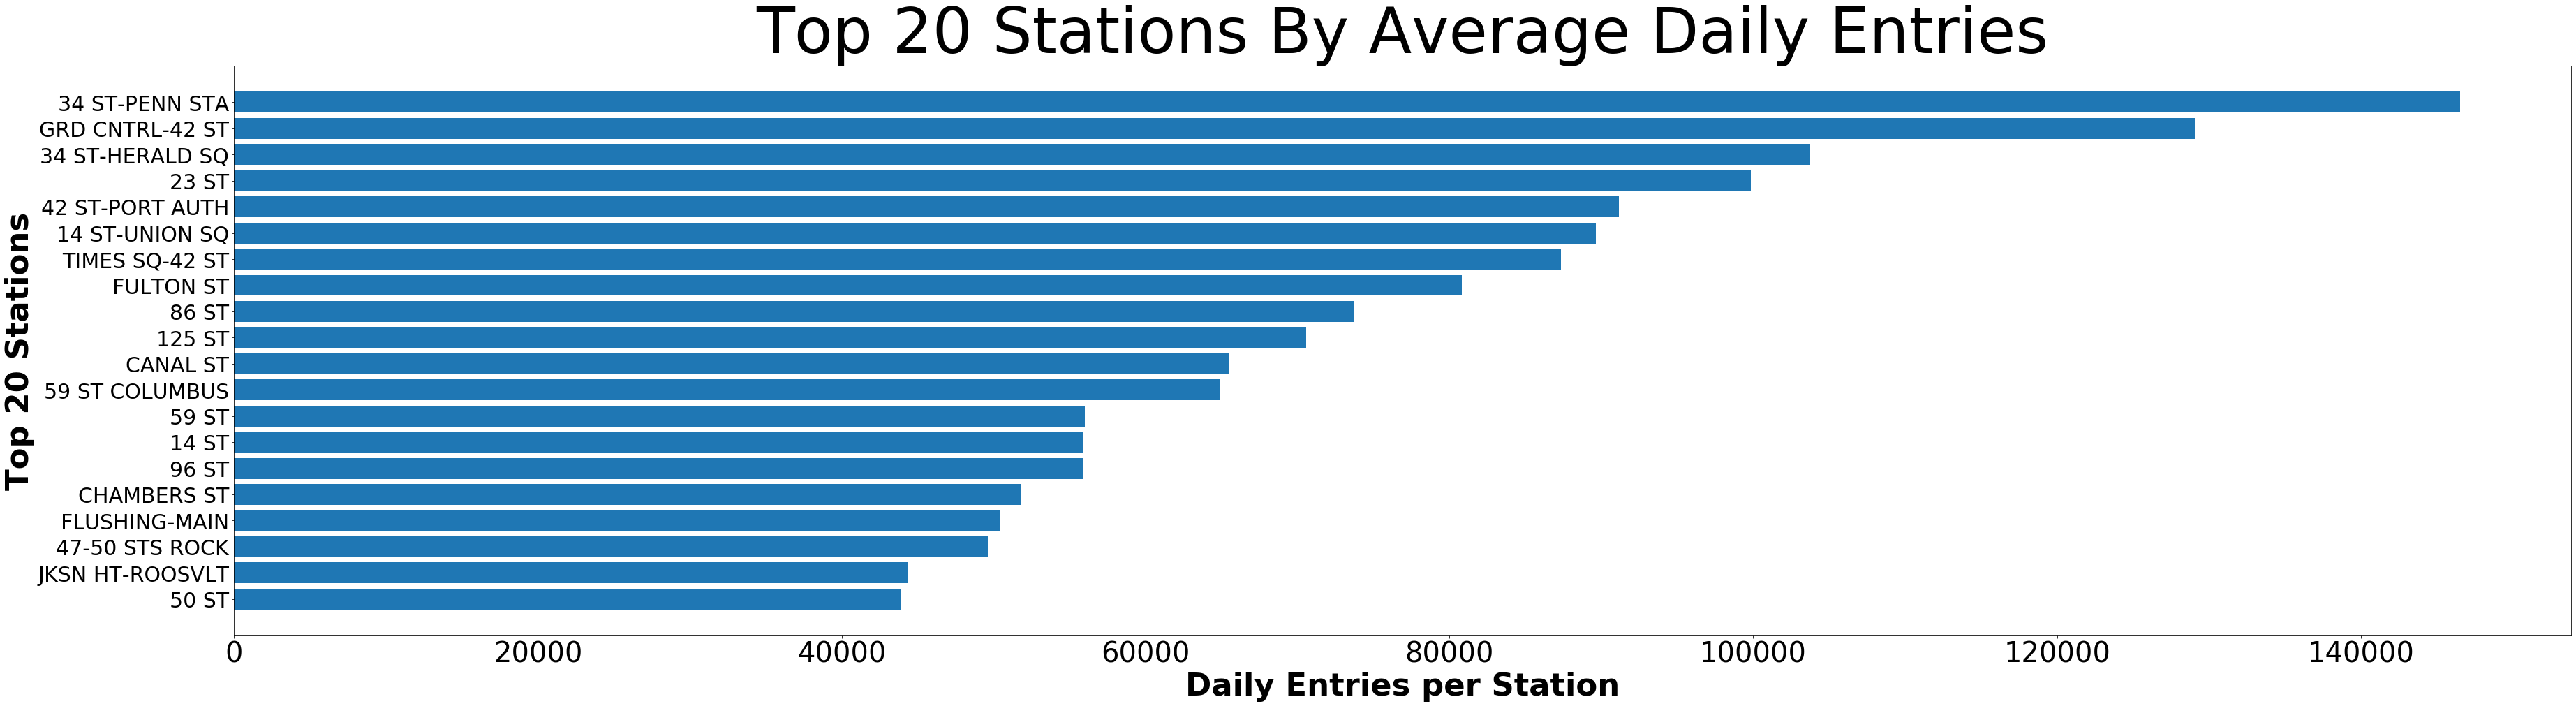

In [23]:
new_x = top_20.STATION
new_y = top_20.entries
#plt.figure(figsize=[480,800])
plt.figure(figsize=(60, 15))

#fig, ax = plt.subplots(20, 5, figsize=(75, 100))

#plt.ax.invert_yaxis()
#plt.subplot(20,5,2)

plt.barh(new_x,new_y)

plt.gca().invert_yaxis()

plt.title('Top 20 Stations By Average Daily Entries',family='sans serif',fontsize = 90,loc='center');
plt.xlabel('Daily Entries per Station',fontsize = 45, weight = 'bold')
plt.ylabel('Top 20 Stations',fontsize = 45, weight = 'bold')
plt.xticks(fontsize=40)
plt.yticks(fontsize=30)

plt.savefig('../src/visualization/top_20.jpg',quality=95)

# Bar Graph All Stations by Average Daily Entries

In [ ]:
new_x = station_dailies_top.STATION
new_y = station_dailies_top.entries
plt.figure(figsize=[50,150])
#fig, ax = plt.subplots(20, 5, figsize=(75, 100))

#plt.ax.invert_yaxis()
plt.subplot(20,5,2)


plt.bar(new_x,new_y)
plt.gca().invert_xaxis()

plt.title('Most Daily Traffic By Stations',family='serif',fontsize = 15,loc='center',color='r');
plt.xlabel('Daily Entries per Station',fontsize = 10, weight = 'bold',color='green')
plt.ylabel('Entries By Daily Average',fontsize = 10, weight = 'bold',color='green')
plt.xticks([]);
#plt.xlabel('Daily Entries per Station',fontsize = 10, weight = 'bold',color='green')


In [37]:
top_20.entries.sum()

1510757.6889344992

In [35]:
station_daily_entries_mean.head(20)

,STATION,entries
0,1 AV,14855.225
1,103 ST,26350.517
2,103 ST-CORONA,17327.706
3,104 ST,4042.170
4,110 ST,9561.537
5,111 ST,12176.794
6,116 ST,29312.364
7,116 ST-COLUMBIA,13221.733
8,121 ST,1909.056
9,125 ST,70553.348


In [40]:
1510757.6889344992/4994075.369

0.3025099897995751

# Daily Traffic Plot 1,2

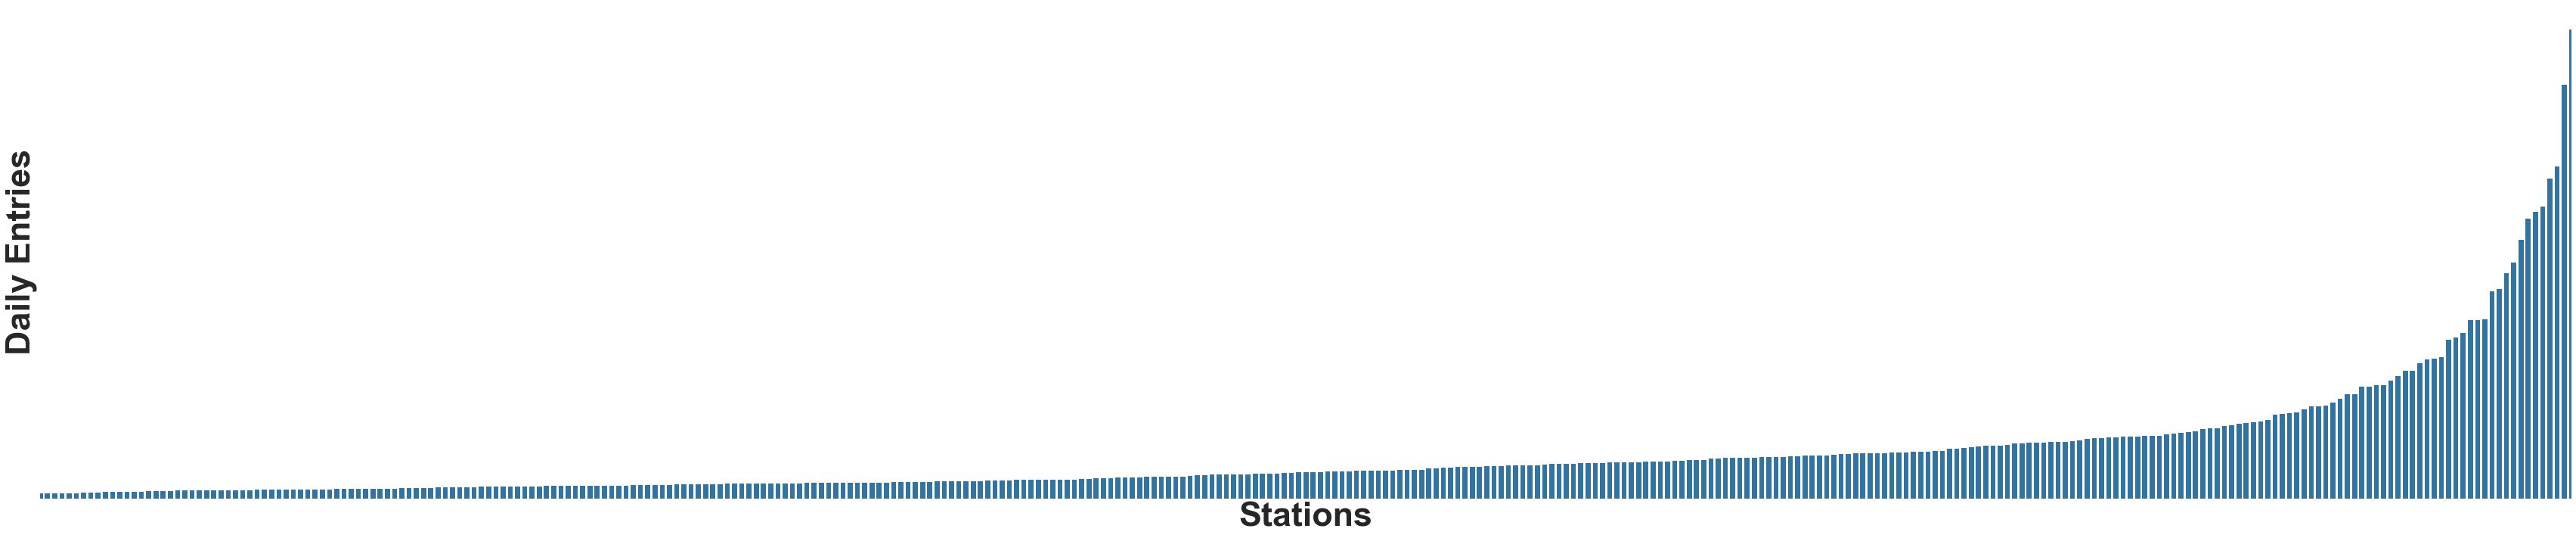

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(60, 12))
#plt.subplot(20,5,2)
#plt.ylabel('Entries By Daily Average',fontsize = 10, weight = 'bold',color='green')

# Load the example car crash dataset
data = station_dailies_top
data2 = top_20

# Plot the total crashes
sns.set_color_codes("bright")
sns.barplot(x="STATION", y="entries", data=data,
            label="Others", color="tab:blue")

#Plot the stations in the top ten
#sns.set_color_codes("bright")
#sns.barplot(x="STATION", y="entries", data=data2,
#            label="Top 20 Stations", color="tab:red")
plt.xticks([])
plt.yticks([])
#g=sns.factorplot(x='type1', col='type2',col_wrap=3, data=dframe, kind='count', sharex=False, sharey=False, palette=pokemon_color_palette)
#plt.title('Daily Traffic By Stations',family='sans serif',fontsize = 30,loc='center',color='r')
plt.xlabel('Stations',fontsize = 45, weight = 'bold')
plt.ylabel('Daily Entries',fontsize = 45, weight = 'bold')


# Add a legend and informative axis label
#ax.legend(ncol=378, loc="upper right", frameon=True)
ax.set(xlim=(350,0))
sns.despine(left=True, bottom=True)
plt.savefig('../src/visualization/dailytraffic1.jpg',quality=95)

## Explore 2

***Finding which days (at which stations) get the most overall daily traffic

In [ ]:
top_days = daily_entries_by_station_by_day.groupby(['DAY','STATION'],as_index=False).agg({'entries':'mean'}).sort_values('entries').tail(20)



In [ ]:
top_days['Station-Day'] = top_days['STATION']+ ' ' +top_days['DAY']

In [31]:
descending_station_top_20

NameError: name 'descending_station_top_20' is not defined

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
data = station_dailies_top.head(20)
data2 = station_dailies_top.head(20)

# Plot the total crashes
#sns.palplot(sns.color_palette("Blues_d"))
sns.set_color_codes("pastel")
sns.barplot(x="entries", y="STATION", data=data,
            label="", color="b")

# Plot the crashes where alcohol was involved
#sns.set_color_codes("muted")
#sns.barplot(x="entries", y="STATION", data=data,
#            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
ax.legend(ncol=10, loc="lower right", frameon=True)
ax.set(xlim=(0,150000), ylabel="Top 20 Stations",
       xlabel="Daily Entries per Station")
sns.despine(left=True, bottom=True)



In [ ]:
new_x = top_days['Station-Day']
new_y = top_days.entries
plt.figure(figsize=[75,100])
#fig, ax = plt.subplots(20, 5, figsize=(75, 100))

#plt.ax.invert_yaxis()
plt.subplot(20,5,2)

plt.barh(new_x,new_y)

plt.title('Busiest Station/Day Combo',family='sans serif',fontsize = 15,loc='center',color='r');
plt.xlabel('Daily Entries per Station',fontsize = 10, weight = 'bold',color='green')
plt.ylabel('Top 20 Stations',fontsize = 10, weight = 'bold',color='green');
